In [586]:
# Making Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as mvn, norm
from math import sqrt, log, exp, pi

In [587]:
# Import the dataset
faithful = pd.read_csv('faithful.csv')

In [588]:
# Obtaining the values
x_vals = faithful['eruptions'].tolist()
y_vals = faithful['waiting']/10
y_vals = y_vals.tolist()

In [589]:
# Defining a class for our Gaussian Mixture model with functions to do the E and M step.  
class GMM_EM:
    def __init__(self, K, data, threshold=10e-4):
        self.K = K
        self.data = data
        self.num_data, self.num_features = self.data.shape
        self.threshold = threshold
       
    
    # Initialize random parameters for mu and cov
    def __get_init_params(self):
        mu = np.random.rand(self.K, self.num_features)
        cov_rand = np.random.rand(self.K)
        cov = []
        for rand in cov_rand:
            cov.append(np.diag([rand, rand]))
        cov = np.array(cov)
        
        pi = []
        remain = 1
        pi_rand = np.random.rand(self.K - 1)
        for rand in pi_rand:
            pi.append(rand)
            remain -= rand * remain
        pi.append(remain)
        pi = np.array(pi)
        return mu, cov, pi

    
    # Function to carry out the E Step
    def __get_expectation(self, mu, cov, pi):
        prob = np.zeros((self.num_data, self.K))
        for k in range(self.K):
            prob[:, k] = mvn.pdf(self.data, mean=mu[k], cov=cov[k])
        resp = np.zeros((self.num_data, self.K))
        for k in range(self.K):
            resp[:, k] = pi[k] * prob[:, k]
        for i in range(self.num_data):
            summ = np.sum(resp[i, :])
            if summ != 0:
                resp[i, :] /= summ
        
        return resp
        
    # Dunction to carry out the M Step  
    def __maximize(self, resp):
        mu = np.zeros((self.K, self.num_features))
        cov = []
        pi = np.zeros(self.K)

        # Update parameters for every model 
        for k in range(self.K):
            sum_resp = np.sum(resp[:, k])
    
            # mean update
            for f in range(self.num_features):
                mu[k, f] = np.sum(np.multiply(resp[:, k], self.data[:, f])) / sum_resp
            
            # covariance update
            cov_k = 0
            for i in range(self.num_data):
                cov_k += resp[i, k] * np.sum(np.square(self.data[i] - mu[k]))
            
            cov_k /= sum_resp
            cov.append(np.diag([cov_k, cov_k]))
            
            # pi
            pi[k] = sum_resp / self.num_data
            
        return mu, cov, pi
        
    
    def __append_mu(self, mus, mu):
        for i in range(self.K):
            for j in range(self.num_features):
                mus[i][j].append(mu[i][j])
        
        
    def run(self, init_mu=None, init_cov=None):
        mu, cov, pi = self.__get_init_params()
        if init_mu is not None:
            mu = init_mu
        if init_cov is not None:
            cov = init_cov
        

        
        mus = [[[] for _ in range(self.num_features)] for __ in range(self.K)]
        self.__append_mu(mus, mu)
        iterations = 0
        log_likelyhoods = []
        while iterations < 2000:
            resp = self.__get_expectation(mu, cov, pi)
            mu, cov, pi = self.__maximize(resp)
            self.__append_mu(mus, mu)
            iterations += 1
            
            log_likelyhood = np.zeros(self.num_data)
            for k in range(self.K):
                log_likelyhood += mvn.pdf(self.data, mean=mu[k], cov=cov[k]) * pi[k]
            
            log_likelyhood = np.sum(np.log10(log_likelyhood))
            log_likelyhoods.append(log_likelyhood)
        
            # noise resistance
            if iterations > 5 and \
               abs(np.mean(log_likelyhoods[iterations - 2 : iterations]) - \
                   np.mean(log_likelyhoods[iterations - 5 : iterations - 2])) \
               / abs(log_likelyhoods[-1]) < 10e-5:
                break
            
        return mu, cov, pi, log_likelyhood

In [590]:
# Scaling the dataset after importing.
data = pd.read_csv('faithful.csv')
scaler = MinMaxScaler()
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data), columns=data.columns)
display(data_scaled)

,eruptions,waiting
0,0.571429,0.679245
1,0.057143,0.207547
2,0.495143,0.584906
3,0.195143,0.358491
4,0.838000,0.792453
...,...,...
267,0.719143,0.716981
268,0.157143,0.056604
269,0.804857,0.886792
270,0.062000,0.056604


In [591]:
# We change the value of K from 2, 3, 4, 5 to obtain the different plots using different components in the multivariate mixture model

K = 5

model = GMM_EM(K, data_scaled.values)
mus, cov, pi, _ = model.run()

In [592]:
# Function to calculate the density at each datapoint
def bidimensional_mixture_normal(x, y, mu, cov, pi_k, K):
    sum = 0
    for k in range(K):
        sum = sum + pi_k[k]*mvn.pdf([x,y],mu[k],cov[k])
    return sum

[]

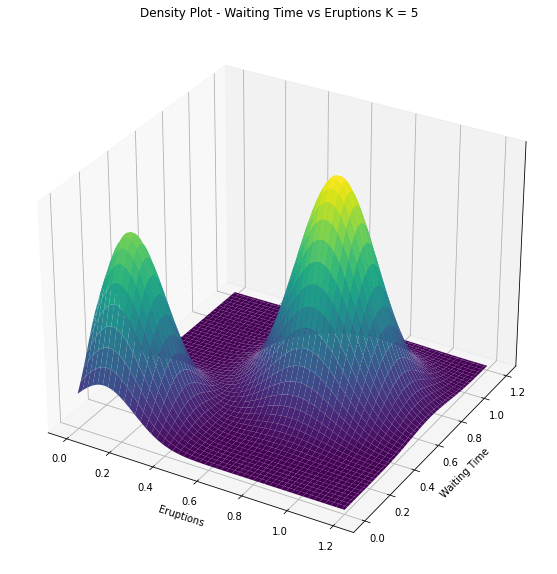

In [596]:
# plot the density function for the current mixture model

density = []
for i in range(len(x_vals)):
    z = bidimensional_mixture_normal(x_vals[i], y_vals[i], mus, cov, pi, K)
    density.append(z)

pdf_list = []
x = np.linspace(0, 6*0.2, num=100)
y = np.linspace(0, 6*0.2, num=100)
X, Y = np.meshgrid(x,y)

pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = bidimensional_mixture_normal(X[i,j], Y[i,j], mus, cov, pi, K)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection = '3d')
ax.plot_surface(X, Y, pdf, cmap = 'viridis')
plt.xlabel("Eruptions")
plt.ylabel("Waiting Time")
plt.title("Density Plot - Waiting Time vs Eruptions K = 5")
pdf_list.append(pdf)
ax.axes.zaxis.set_ticks([])

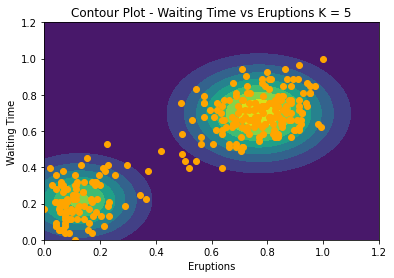

In [597]:
# Plot the contour plot for the current mixture model.

for idx, val in enumerate(pdf_list):
    plt.contourf(X, Y, val)
    plt.xlabel("Eruptions")
    plt.ylabel("Waiting Time")
    plt.scatter(data_scaled['eruptions'], data_scaled['waiting'], color = "orange")
    plt.title("Contour Plot - Waiting Time vs Eruptions K = 5")
plt.show()

In [598]:
# Calculate the AIC values
def calculate_aic(data):
    aic_k = []
    k_vals = [2,3,4,5]
    k_indicator = 0 
    for k in k_vals:
        model = GMM_EM(k, data.values)
        _,_,_,ll = model.run()
        aic_k.append(2*(-1*ll + k_vals[k_indicator]))
    return aic_k

In [599]:
aic_k = calculate_aic(data_scaled)

In [600]:
aic_k

[138.57869948618787, 136.87965618032885, -180.9112823836408, -180.932910192116]

In [601]:
# Calculate the BIC Values. 

def calculate_bic(data):
    bic_k = []
    k_vals = [2,3,4,5]
    k_indicator = 0 
    for k in k_vals:
        model = GMM_EM(k, data.values)
        _,_,_,ll = model.run()
        bic_k.append(2*(-1*ll )+ k_vals[k_indicator]*log(len(data)))
    return bic_k

In [602]:
bic_k = calculate_bic(data_scaled)

In [603]:
bic_k

[-173.69798742950243,
 -173.69936788823077,
 -173.7003814046246,
 -173.8072267144722]